In [1]:
import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import pickle
import numpy as np
import scipy as sc
import scipy.interpolate
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import symbtools as st
import symbtools.modeltools as mt
import symbtools.noncommutativetools as nct

mathematisches Pendel der Länge $l$ 

$\varphi=0$ entspricht der oberen Ruhelage

In [2]:
t = sp.Symbol('t')
Np = 1
Nq = 1
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))
aa = st.symb_vector("a1:{0}".format(Nq+1))
ww = st.symb_vector("w1:{0}".format(Nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

In [3]:
params = sp.symbols('m1, m2, l, g') # m1 wagen, m2 pole
st.make_global(params)

tau1 = sp.Symbol("tau1")

In [4]:
#Einheitsvektoren
ex = sp.Matrix([1,0])
ey = sp.Matrix([0,1])


# Koordinaten der Schwerpunkte und Gelenke
S1 = ex*q1 # Schwerpunkt Wagen
G2 = S1 # Pendel-Gelenk

# Schwerpunkt des Pendels (Pendel zeigt für kleine Winkel nach #! OBEN)
S2 = G2 + sp.Matrix([l * sin(p1), l*cos(p1)]) 

# Zeitableitungen der Schwerpunktskoordinaten
Sd1, Sd2  = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##

In [5]:
# Energie
T_rot = 0 # (Punktmassenmodell)
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 )/2

T = T_rot + T_trans[0]

V = m2*g*S2[1]

In [6]:
S2

Matrix([
[l*sin(p1) + q1],
[     l*cos(p1)]])

In [7]:
Sd2

Matrix([
[l*pdot1*cos(p1) + qdot1],
[       -l*pdot1*sin(p1)]])

In [8]:
T_trans

Matrix([[l**2*m2*pdot1**2*sin(p1)**2/2 + m1*qdot1**2/2 + m2*(l*pdot1*cos(p1) + qdot1)**2/2]])

In [9]:
T_trans[0]

l**2*m2*pdot1**2*sin(p1)**2/2 + m1*qdot1**2/2 + m2*(l*pdot1*cos(p1) + qdot1)**2/2

In [10]:
L = T_trans[0] + V
dLdqd = sp.Derivative(L, tthetad).doit().simplify()
dLdq = sp.Derivative(L, ttheta).doit().simplify()
ddLdqddt = st.time_deriv(dLdqd, ttheta).simplify()
ddLdqddt


Matrix([
[         l*m2*(l*pddot1 - pdot1*qdot1*sin(p1) + qddot1*cos(p1))],
[m1*qddot1 + m2*(l*pddot1*cos(p1) - l*pdot1**2*sin(p1) + qddot1)]])

In [11]:
mod = mt.generate_symbolic_model(T, V, ttheta, [0, tau1])

In [12]:
mod.MM.simplify()
mod.MM

Matrix([
[     l**2*m2, l*m2*cos(p1)],
[l*m2*cos(p1),      m1 + m2]])

In [13]:
mod.eqns

Matrix([
[                         l*m2*(-g*sin(p1) + l*pddot1 + qddot1*cos(p1))],
[m1*qddot1 + m2*(l*pddot1*cos(p1) - l*pdot1**2*sin(p1) + qddot1) - tau1]])

In [14]:
mod.calc_state_eq(simplify=True)
sp.simplify(mod.state_eq)

Matrix([
[                                                                                  pdot1],
[                                                                                  qdot1],
[(g*(m1 + m2)*sin(p1) - (l*m2*pdot1**2*sin(p1) + tau1)*cos(p1))/(l*(m1 + m2*sin(p1)**2))],
[                (-g*m2*sin(2*p1)/2 + l*m2*pdot1**2*sin(p1) + tau1)/(m1 + m2*sin(p1)**2)]])

In [15]:
repr(sp.simplify(mod.state_eq))


'Matrix([\n[                                                                                  pdot1],\n[                                                                                  qdot1],\n[(g*(m1 + m2)*sin(p1) - (l*m2*pdot1**2*sin(p1) + tau1)*cos(p1))/(l*(m1 + m2*sin(p1)**2))],\n[                (-g*m2*sin(2*p1)/2 + l*m2*pdot1**2*sin(p1) + tau1)/(m1 + m2*sin(p1)**2)]])'

In [16]:
sp.simplify(mod.state_eq.subs(l, 4/3*l))

Matrix([
[                                                                                                        pdot1],
[                                                                                                        qdot1],
[0.75*(g*(m1 + m2)*sin(p1) - (1.33333333333333*l*m2*pdot1**2*sin(p1) + tau1)*cos(p1))/(l*(m1 + m2*sin(p1)**2))],
[                     (-g*m2*sin(2*p1)/2 + 1.33333333333333*l*m2*pdot1**2*sin(p1) + tau1)/(m1 + m2*sin(p1)**2)]])

In [17]:
mod.calc_coll_part_lin_state_eq(simplify=True)

In [18]:
xx = mod.x ##:T
f = mod.ff ##:
G = mod.gg 
g1, = st.col_split(G) ##:
xx

Matrix([
[   p1],
[   q1],
[pdot1],
[qdot1]])

In [19]:
f

Matrix([
[      pdot1],
[      qdot1],
[g*sin(p1)/l],
[          0]])

In [20]:
G

Matrix([
[         0],
[         0],
[-cos(p1)/l],
[         1]])

In [21]:
eqp1 = sp.Matrix([0, 0, 0, 0 ]) # obere RL
eqp2 = sp.Matrix([-sp.pi, 0, 0, 0]) # untere RL

# Probe:
f.subz(xx, eqp1) ##:T
f.subz(xx, eqp2) ##:T

Matrix([
[0],
[0],
[0],
[0]])

In [22]:
# Parameterwerte
parameter_values = [(g, 9.81), (l, .5)]
replm =  parameter_values + list(zip(xx, eqp2)) ##
replm

[(g, 9.81), (l, 0.5), (p1, -pi), (q1, 0), (pdot1, 0), (qdot1, 0)]

In [23]:
A1 = f.jacobian(xx).subs(replm) ##
A1

Matrix([
[     0, 0, 1, 0],
[     0, 0, 0, 1],
[-19.62, 0, 0, 0],
[     0, 0, 0, 0]])

In [24]:
b1 = G.subs(replm) ##
b1

Matrix([
[  0],
[  0],
[2.0],
[  1]])

In [25]:
def F_env_order(F):
    return [F[0,1], F[0,3], F[0,0], F[0,2]]

In [26]:
def normalize_F(F):
    return F / F[0]

In [27]:
a = 1.2
b = 3.4

poles = np.r_[-1.5+a*1j, -1.5-a*1j, -1.3 + b*1j, -1.3 - b*1j] ##:
# poles = np.linspace(-5, -8, 4)
# k1 = st.siso_place(A1, b1, poles)
# print(k1)
# A1-b1@k1
import control as ctrl
F = ctrl.place(np.array(A1, dtype=float), np.array(b1, dtype=float), poles)
print("F", F)
print("F in env order of x, xdot, phi, phidot:")
F_env = F_env_order(F)
print(F_env)
np.linalg.eigvals(np.array(A1, dtype=float) - np.array(b1, dtype=float) @ F)

F [[1.31401376 2.49197248 1.54250765 2.51498471]]
F in env order of x, xdot, phi, phidot:
[2.491972477064221, 2.514984709480121, 1.314013761467891, 1.5425076452599387]


array([-1.3+3.4j, -1.3-3.4j, -1.5+1.2j, -1.5-1.2j])

LQR

In [28]:
from scipy.linalg import solve_continuous_are
# Q = np.diag([1000, 1000, 1000, 1000])
Q = np.diag([30, 30, 30, 30])
R = 1
A = np.array(A1, dtype=float)
B = np.array(b1, dtype=float)
P = solve_continuous_are(A, B, Q, R)
# print(P)
K = 1/R * B.T @ P
F_LQR = F_env_order(K)
print(F_LQR)
print(normalize_F(F_LQR))

[5.477225575051655, 7.852806746015714, 18.548252241566498, 3.74085591757913]
[1.         1.4337198  3.38643205 0.68298372]


In [24]:
# calculate Q from given F
F_NN = np.array([[16.94674301,  31.63287544, 150.45680237,  40.50919724]])
p = [sp.var(f"p{i}") for i in range(16)]
P = sp.Matrix(np.array(p).reshape(4,4))
sol = sp.solve(b1.T@P-sp.Matrix(F_NN), P)
P_num = P.subs(sol).subs([("p2", sol[p[8]]), ("p6", sol[p[9]]), ("p14", sol[p[11]])]).subs(zip(p, sp.ones(16,1)))
# print(P_num)
assert np.sum(B.T@P_num - F_NN) == 0
Q = -(A.T@P_num + P_num@A-P_num@B@B.T@P_num)
print(Q.eigenvals())
Q = np.array(Q, dtype=float)



{25909.0629821017: 1, -81.4629715292655: 1, 33.4969336287814: 1, -0.0932416710619695: 1}


In [25]:
k1 = st.siso_place(A1, b1, poles)##:T

controller1_expr1 = k1.T*mod.xx
controller1_func_intern = st.expr_to_func(mod.xx, k1.T*mod.xx)

def controller1_func(xx, t):
    # Zeit t ignorieren
    return controller1_func_intern(*xx)

k1

Matrix([
[-1.31401376146789],
[-2.49197247706422],
[-1.54250764525994],
[-2.51498470948012]])

In [26]:
# Probe
A = A1 + b1*k1.T
A.eigenvals(rational=False)

{-1.3 - 3.4*I: 1, -1.3 + 3.4*I: 1, -1.5 - 1.2*I: 1, -1.5 + 1.2*I: 1}

In [27]:
# Zeit-Array und Anfangswerte
tt = np.arange(0, 10, 1e-3)
xx0 = [3, 0, 0, 0] ##

#Erstellung des Simulationsmodells
sm = st.SimulationModel(mod.ff, mod.gg, mod.xx, model_parameters=parameter_values)
rhs1 = sm.create_simfunction(controller_function=controller1_func)

# Durchführung der Simulation
res = odeint(rhs1, xx0, tt)
X1, X2, X3, X4 = res.T
aa1 = controller1_func_intern(X1, X2, X3, X4)

c:\Users\Julius Fiedler\anaconda3\envs\da\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


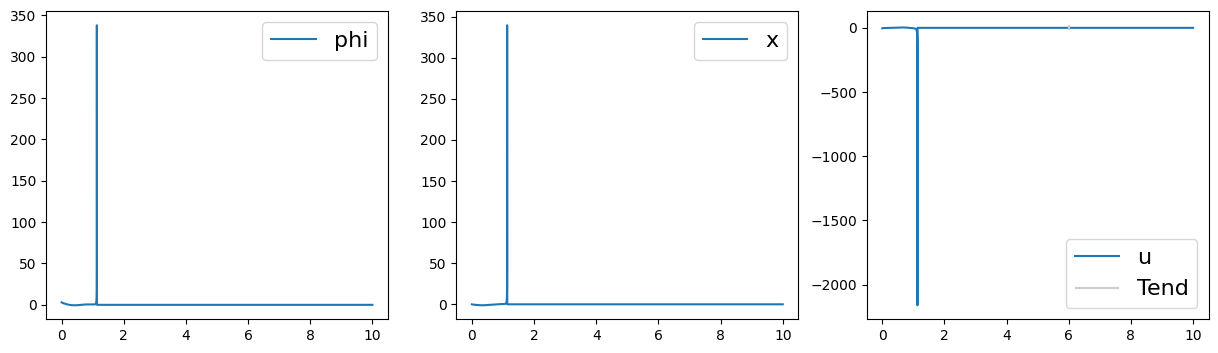

In [28]:
T_fin = 6
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
plt.plot(tt, X1, label="phi")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 3, 2)
plt.plot(tt, X2, label="x")
plt.legend(loc='best', fontsize=16)
plt.subplot(1, 3, 3)
plt.plot(tt, aa1, label="u")
plt.vlines([T_fin], -20, 20, color='0.8', label=r'Tend')
plt.legend(loc='best', fontsize=16)

Simulation

In [29]:
from scipy.integrate import solve_ivp
def rhs(t, state):
    x, x_dot, theta, theta_dot = state
    x1, x2, x3, x4 = x, theta, x_dot, theta_dot # change order
    g = 9.8
    l = 0.5
    m1 = 1.0
    m2 = 0.1
    F = np.array([[-23.42598624,  -2.49197248,  -4.05749235,  -2.51498471]])
    u1 = - F @ np.array([x1, x2, x3, x4])
    dx1_dt = x3
    dx2_dt = x4
    dx3_dt = (-g*m2*np.sin(2*x2)/2 + l*m2*theta_dot**2*np.sin(x2) + u1)/(m1 + m2*np.sin(x2)**2)
    dx4_dt = (g*(m1 + m2)*np.sin(x2) - (l*m2*theta_dot**2*np.sin(x2) + u1)*np.cos(x2))/\
        (l*(m1 + m2*np.sin(x2)**2))
    
    return [dx1_dt, dx3_dt, dx2_dt, dx4_dt] # change order back

tend = 10
tt = np.linspace(0, tend, 2000)
xx0 = [0, 0, 0.01, 0]
s = solve_ivp(rhs, (0, tend), xx0, t_eval=tt)
labels = ["x", "xdot", "phi", "phidot"]
for i in range(4):
    plt.plot(s.t, s.y[i], label=labels[i])
plt.legend()
plt.show()

KeyboardInterrupt: 